# Simple two-locus BDMI simulations

## Install libraries

In [18]:
import sys, os
import numpy as np
import pandas as pd

from numpy.random import gamma

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set_style('white')

from multiprocess import Pool, cpu_count # multiprocess, not multiprocessing
from tqdm.auto import trange, tqdm

## Two-locus model

In [19]:

def compute_twolocus_sample_data(N, M, s, g, startmix=1, bdmi=True, pos_s=0, gamma_s=False):
    
    if gamma_s:
        s = gamma(2, s/2, 1)[0]    
    
    m = M / N
    
    data = np.empty((g, 2, 4)) # gen, pop, alleles A, a, B, b (pops start out as AA bb, and aa BB, e.g. freq pop1: 1,1,0,0)
    
    data[0][0] = np.array([1-startmix, startmix, startmix, 1-startmix])
    data[0][1] = np.array([startmix, 1-startmix, 1-startmix, startmix])

    for g in range(1, g):
        # new generations
        for pop in range(2):

            f_A, f_a, f_B, f_b = data[g-1][pop]
            
            # construct genotypes
            locus1_genotypes = (f_A*f_A, 2*f_A*f_a, f_a*f_a)
            locus2_genotypes = (f_B*f_B, 2*f_B*f_b, f_b*f_b)
            
            # two locus genotypes
            genotypes = []
            for i in locus1_genotypes:
                row = []
                for j in locus2_genotypes:
                    row.append(i*j)
                genotypes.append(row)
            genotypes = np.array(genotypes)
            assert round(genotypes.sum(), 10) == 1, genotypes.sum()

            if bdmi:
                # selection against A B combinations (BDMI)
                sel = np.array([[1-2*s, 1-2*s, 1],
                                [1-2*s, 1-s, 1],
                                [1,   1,   1]])
            else:
                # just selection against B in pop 0 and A in pop 1 (ecological selection)
                if pop == 0:
                    sel = np.array([[1-2*s, 1-s, 1],
                                    [1-2*s, 1-s, 1],
                                    [1-2*s, 1-s, 1]])
                else:
                    sel = np.array([[1-2*s, 1-2*s, 1-2*s],
                                    [1-s, 1-s, 1-s],
                                    [1,   1,   1]])
            if pos_s:
                # positive selection on A and B
                a = np.array([1+2*pos_s, 1+pos_s, 1])
                if pop == 0:
                    sel = (sel.T * a).T
                else:
                    sel = sel * a

            genotypes_sampling_prob = genotypes * sel
            genotypes_sampling_prob /= genotypes_sampling_prob.sum()
            assert round(genotypes_sampling_prob.sum(), 10) == 1, genotypes_sampling_prob.sum()
            
            counts = np.random.multinomial(N, genotypes_sampling_prob.flatten()).reshape((3, 3))

            f_A = counts[0, :].sum()*2 + counts[1, :].sum()
            f_a = counts[1, :].sum() + counts[2, :].sum()*2
            f_A, f_a = f_A / (f_A + f_a), f_a / (f_A + f_a)
            
            f_B = counts[:, 0].sum()*2 + counts[:, 1].sum()
            f_b = counts[:, 1].sum() + counts[:, 2].sum()*2
            f_B, f_b = f_B / (f_B + f_b), f_b / (f_B + f_b)

            new_freqs = np.array([f_A, f_a, f_B, f_b])
            assert round(new_freqs.sum(), 10) == 2, new_freqs
            data[g][pop] = new_freqs

        data[g][0], data[g][1] = (1-m)*data[g][0] + m*data[g][1], (1-m)*data[g][1] + m*data[g][0]

    return data


## Plot of single simulation

In [20]:
def plot(labels=['A', 'a', 'B', 'b']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
    for x, label in zip(data[:, 0, :].transpose(), labels):
        ax1.plot(x, label=label)
    ax1.legend()    
    ax2.set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
    for x, label in zip(data[:, 1, :].transpose(), labels):
        ax2.plot(x, label=label)   
    ax2.legend() ;

    ax1.set_xlim(left=0)
    ax2.set_xlim(left=0)
    ax1.axhline(y=1-startmix, linestyle='dotted', color='black')
    ax1.axhline(y=startmix, linestyle='dotted', color='black')
    ax2.axhline(y=1-startmix, linestyle='dotted', color='black')
    ax2.axhline(y=startmix, linestyle='dotted', color='black') ;

## Reproducing a BDMI plot like in Shumer et al

- Instant mixing (`startmix`) of populations with no subsequent migration
- It is assumed that there is no positive selection on A and B. I.e. the BDMI has developed neutrally.

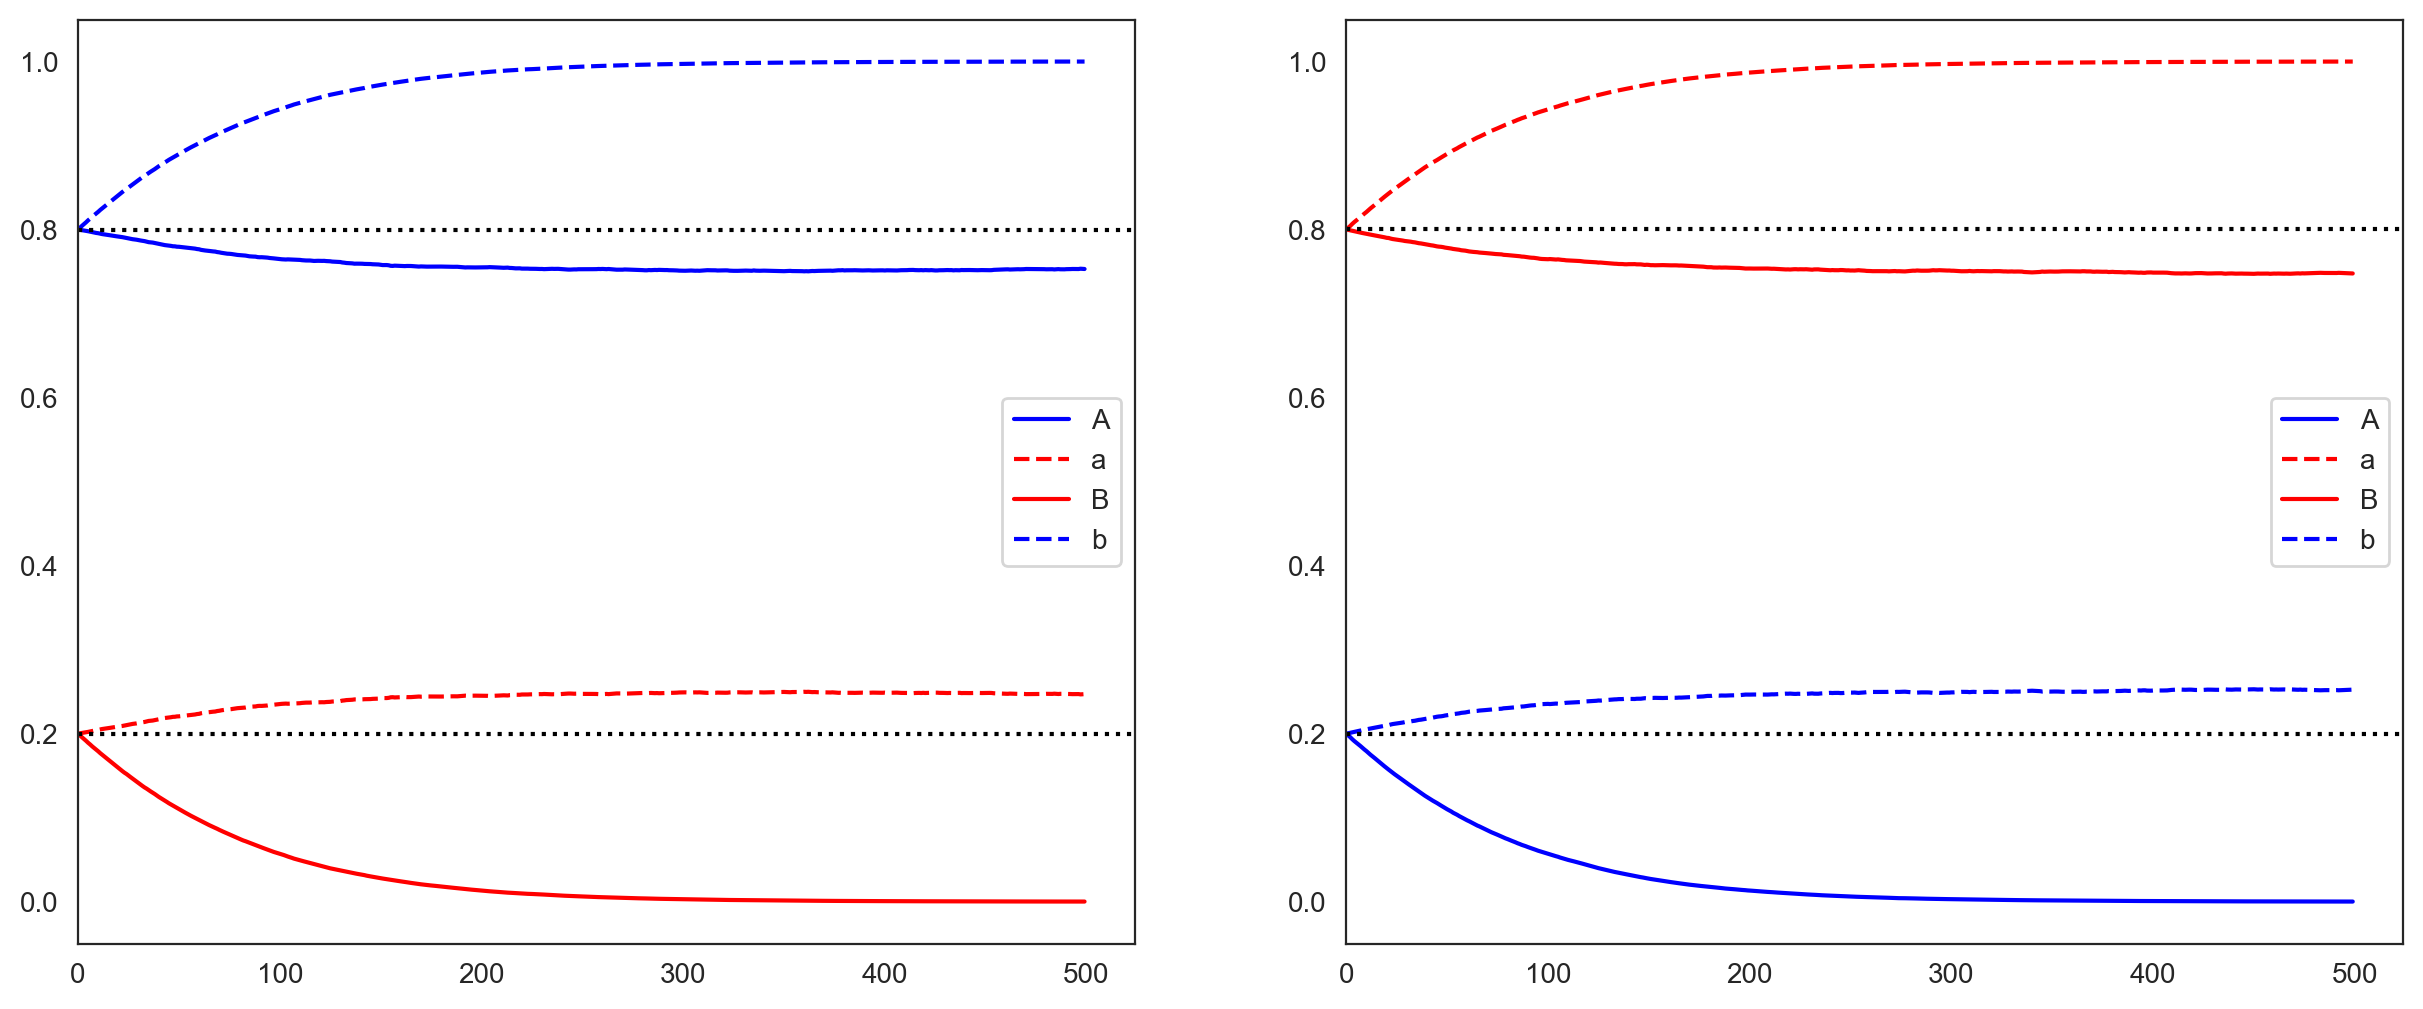

In [21]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 0, 0.01, 500, startmix=startmix, bdmi=True)
plot()

## Adding positive selection on A and B

Even with a a bit of selection on A and B over a and b the positive correlation becomes negative very quickly:

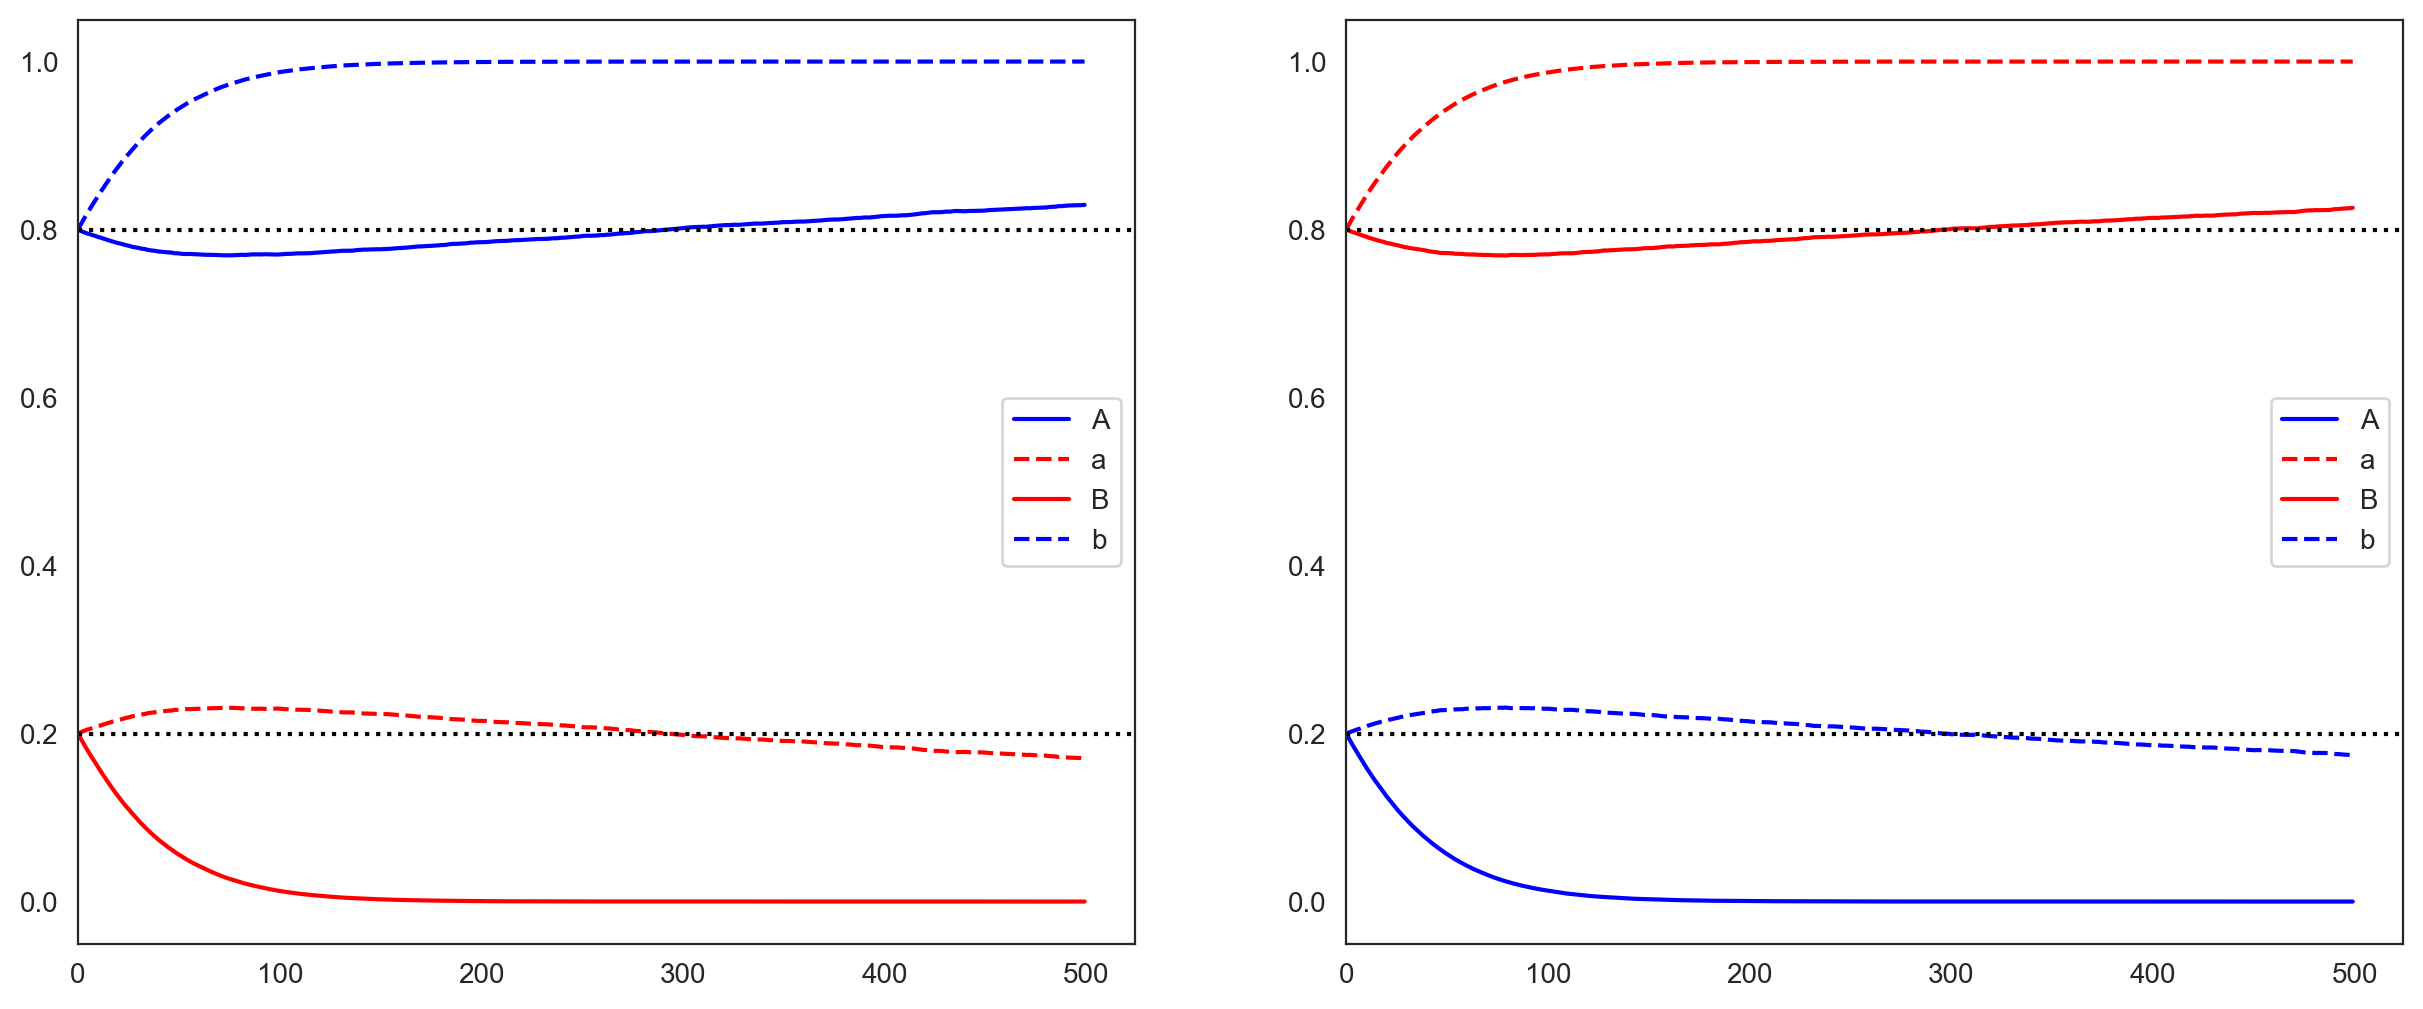

In [24]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 0, 0.02, 500, startmix=startmix, bdmi=True, pos_s=0.001)
plot()

## No BDMI but with negative selection and migration

- Instant mixing of populations *and* subsequent migration
- No BDMI, only negative selection on B in pop1 and A in pop 2

Produces a positive correlation. So *with* migration, the correlation is can produced by ecological selection.

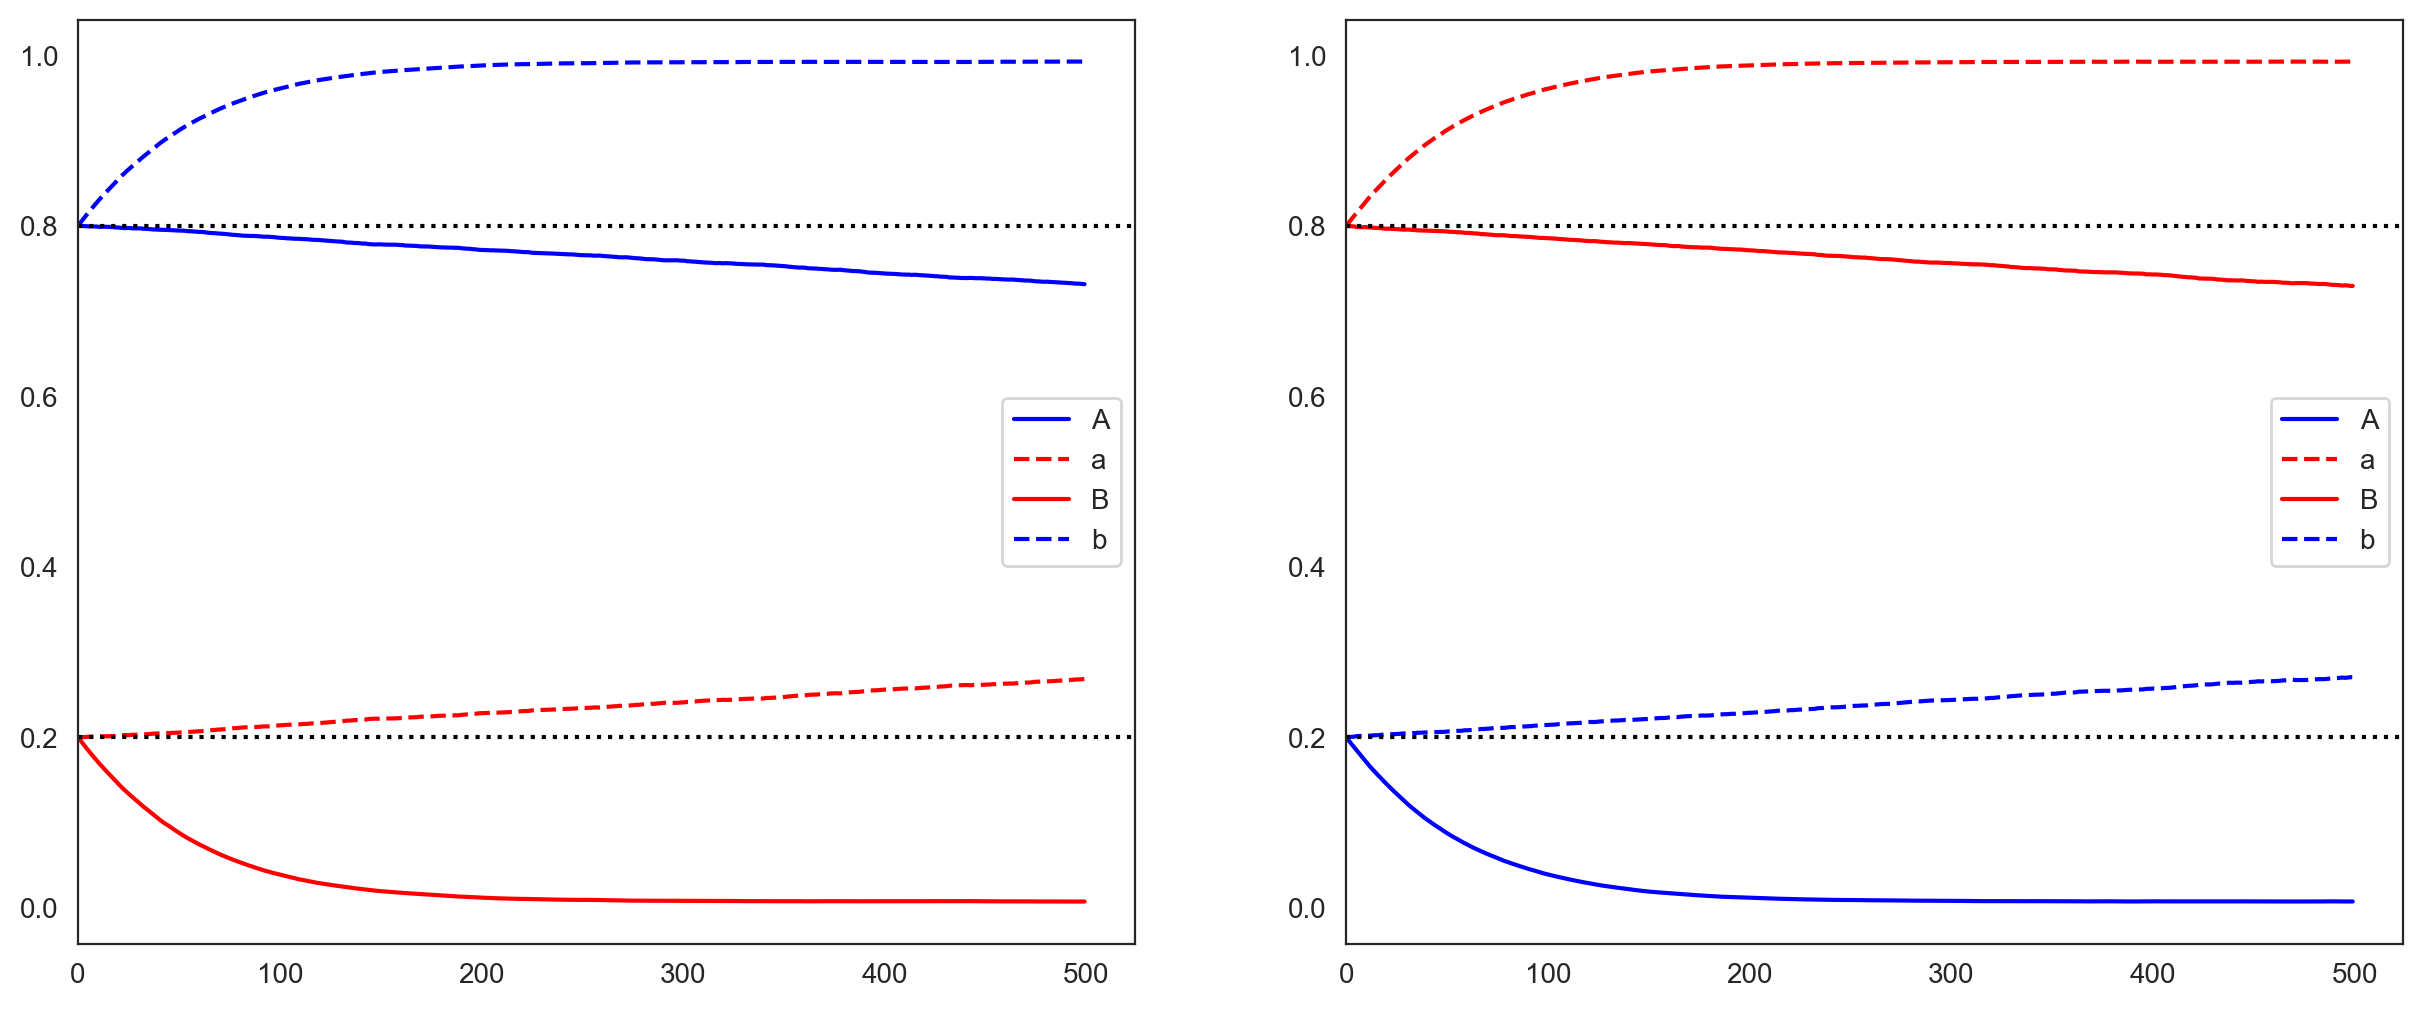

In [27]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 1000, 0.02, 500, startmix=startmix, bdmi=False)
plot()

This kind of assymetric negative selection (only selection on A and B in each population) eventually leads to loss of A and B.

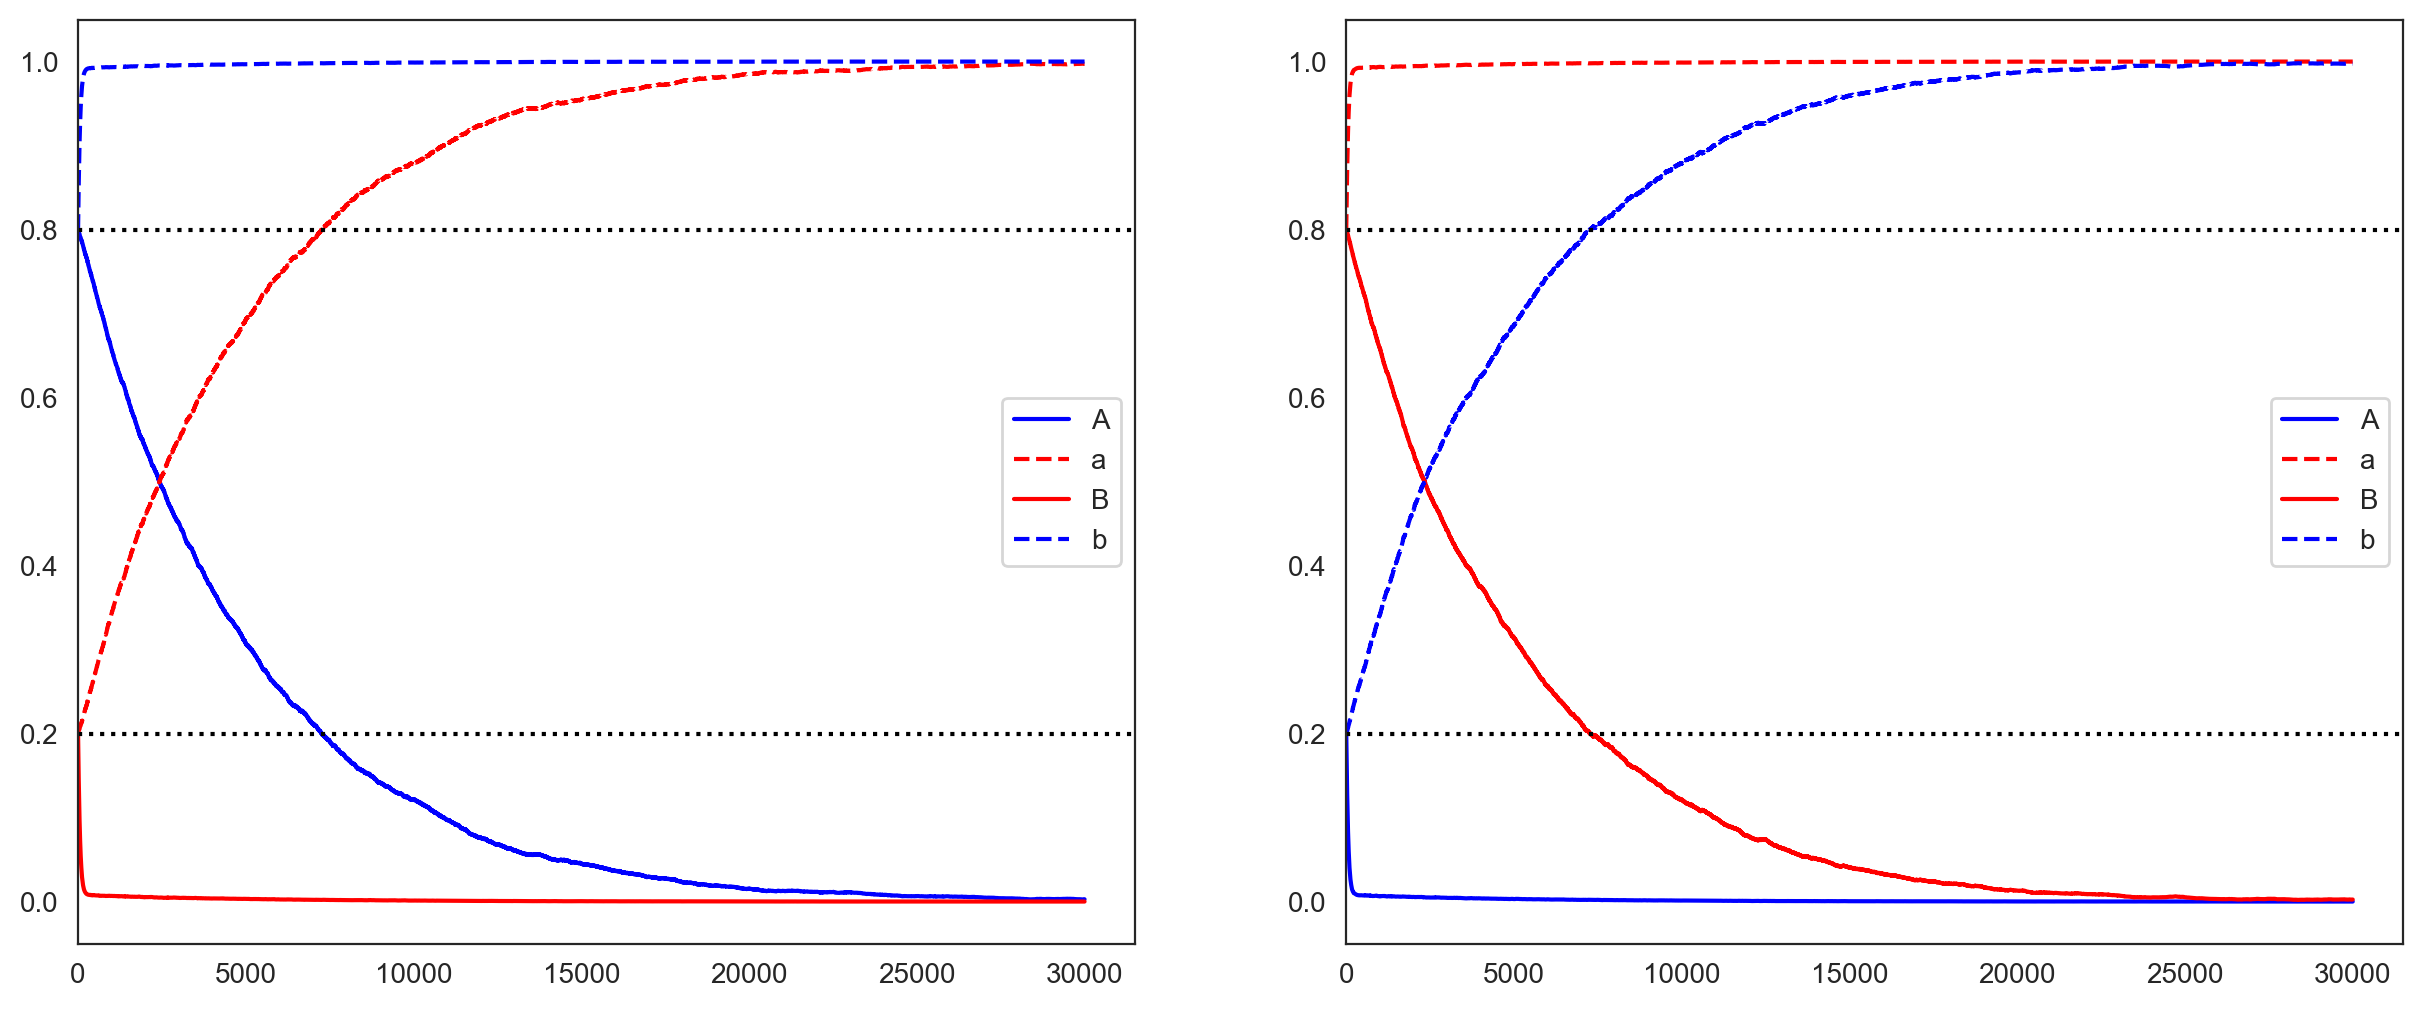

In [28]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 1000, 0.02, 30000, startmix=startmix, bdmi=False)
plot()

## Neutral simulation with only migration

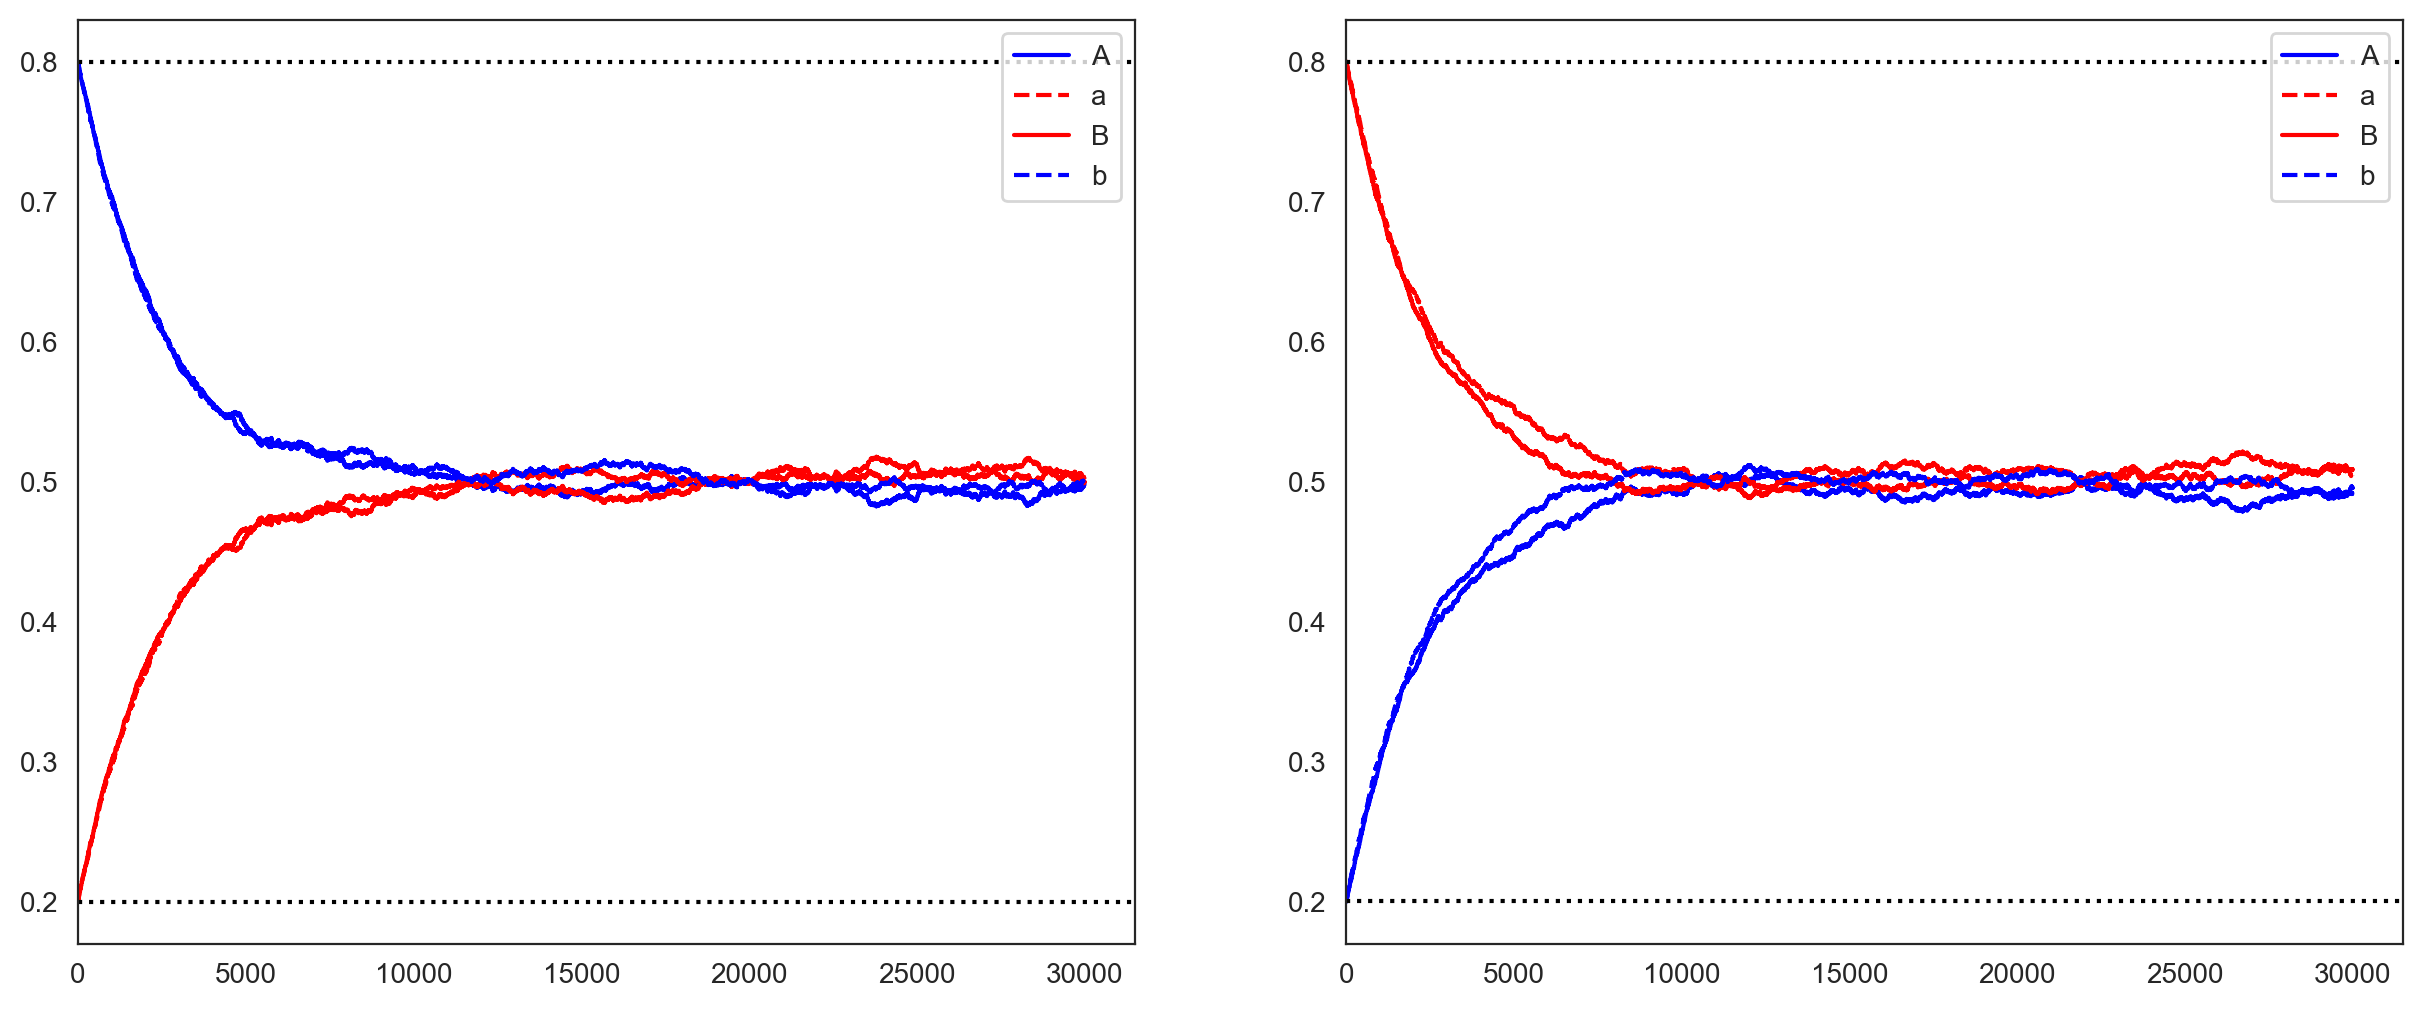

In [29]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 1000, 0.0, 30000, startmix=startmix, bdmi=False)
plot()

## Both BDMI and migration

- Both BDMI and subsequenct migration procudes a strong combined effect.

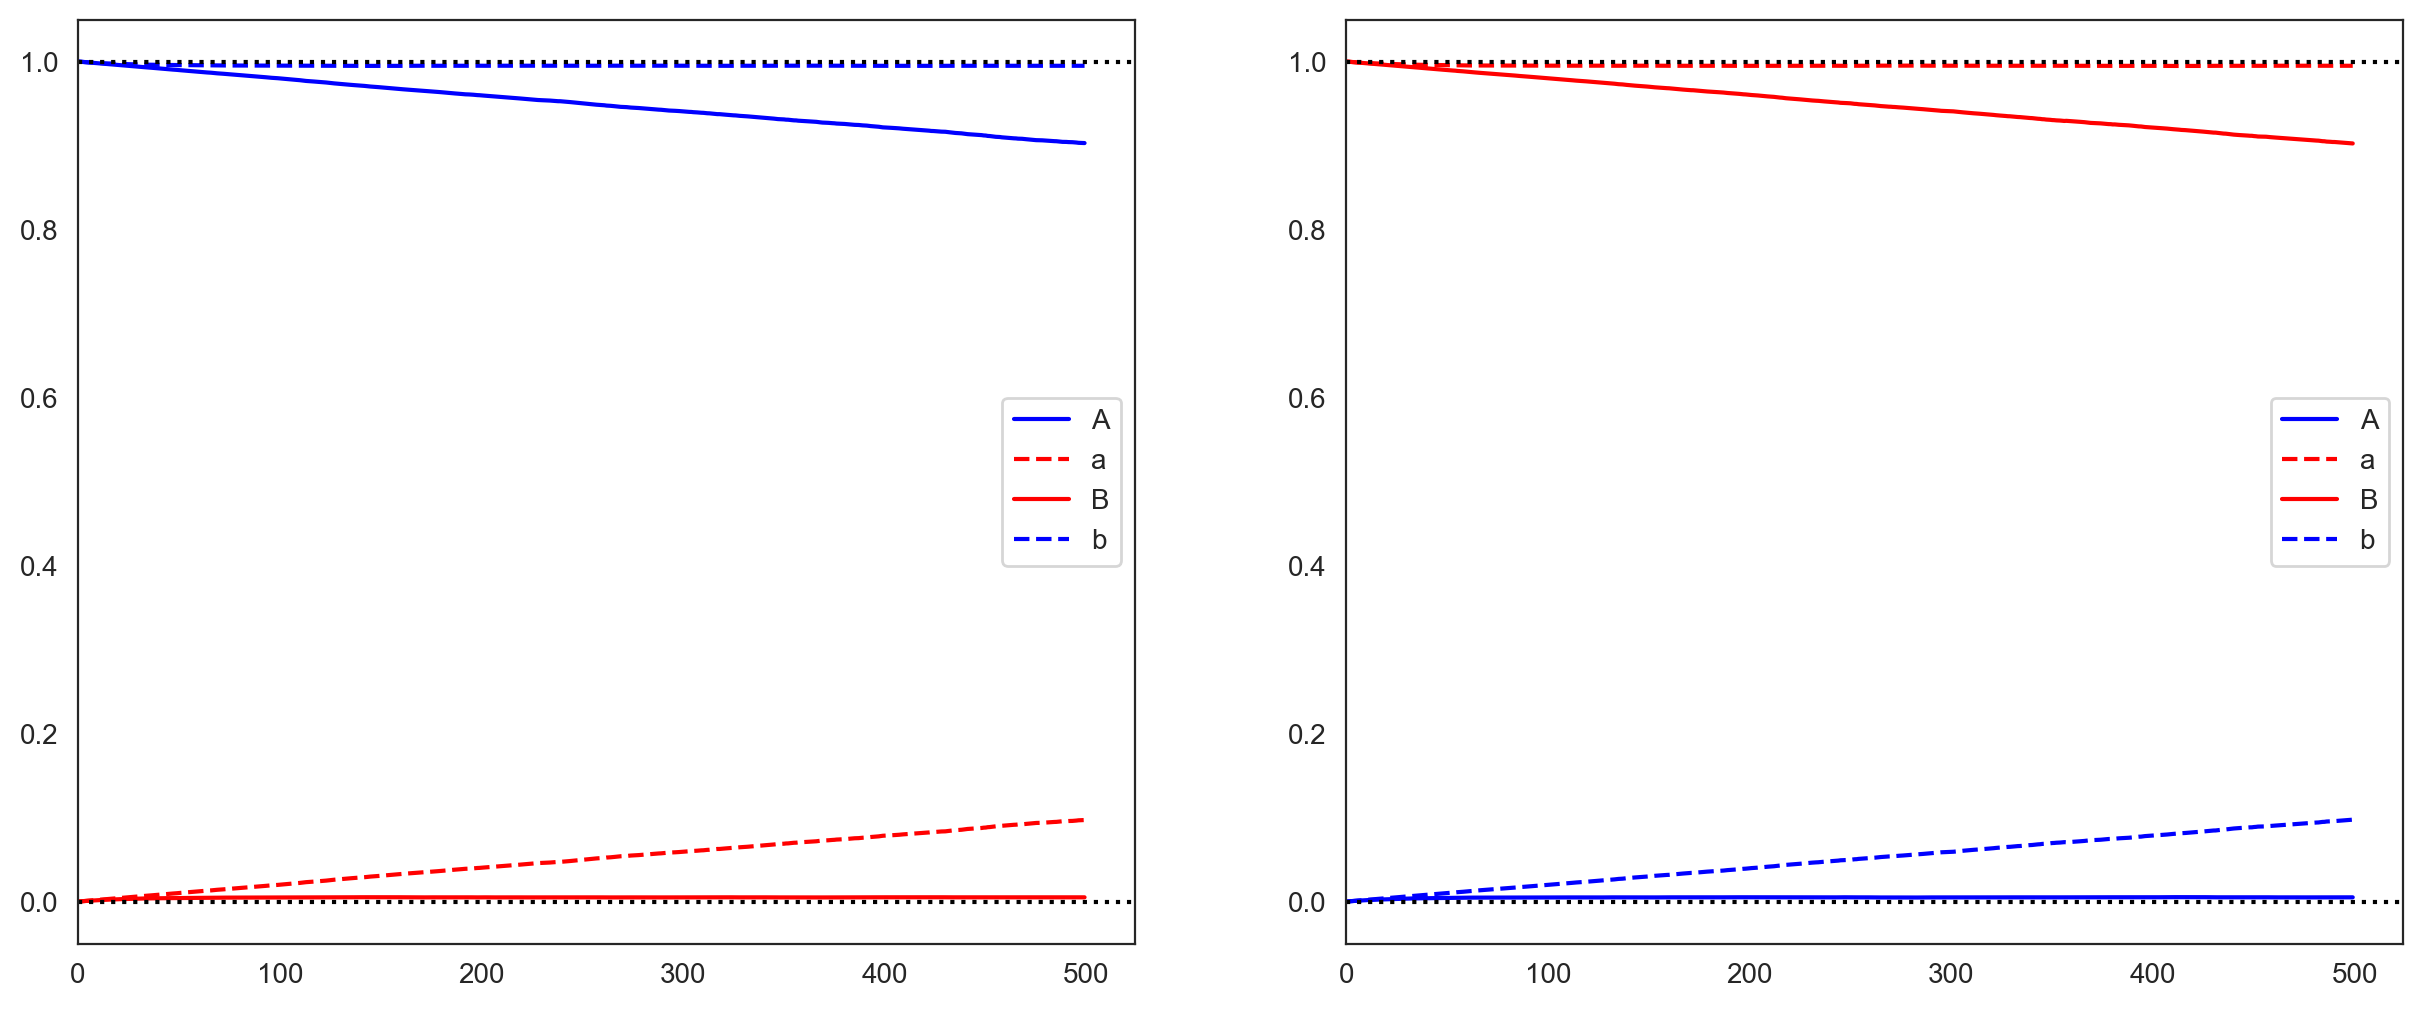

In [31]:
startmix = 0
data = compute_twolocus_sample_data(5000000, 1000, 0.02, 500, startmix=startmix, bdmi=True)
plot()

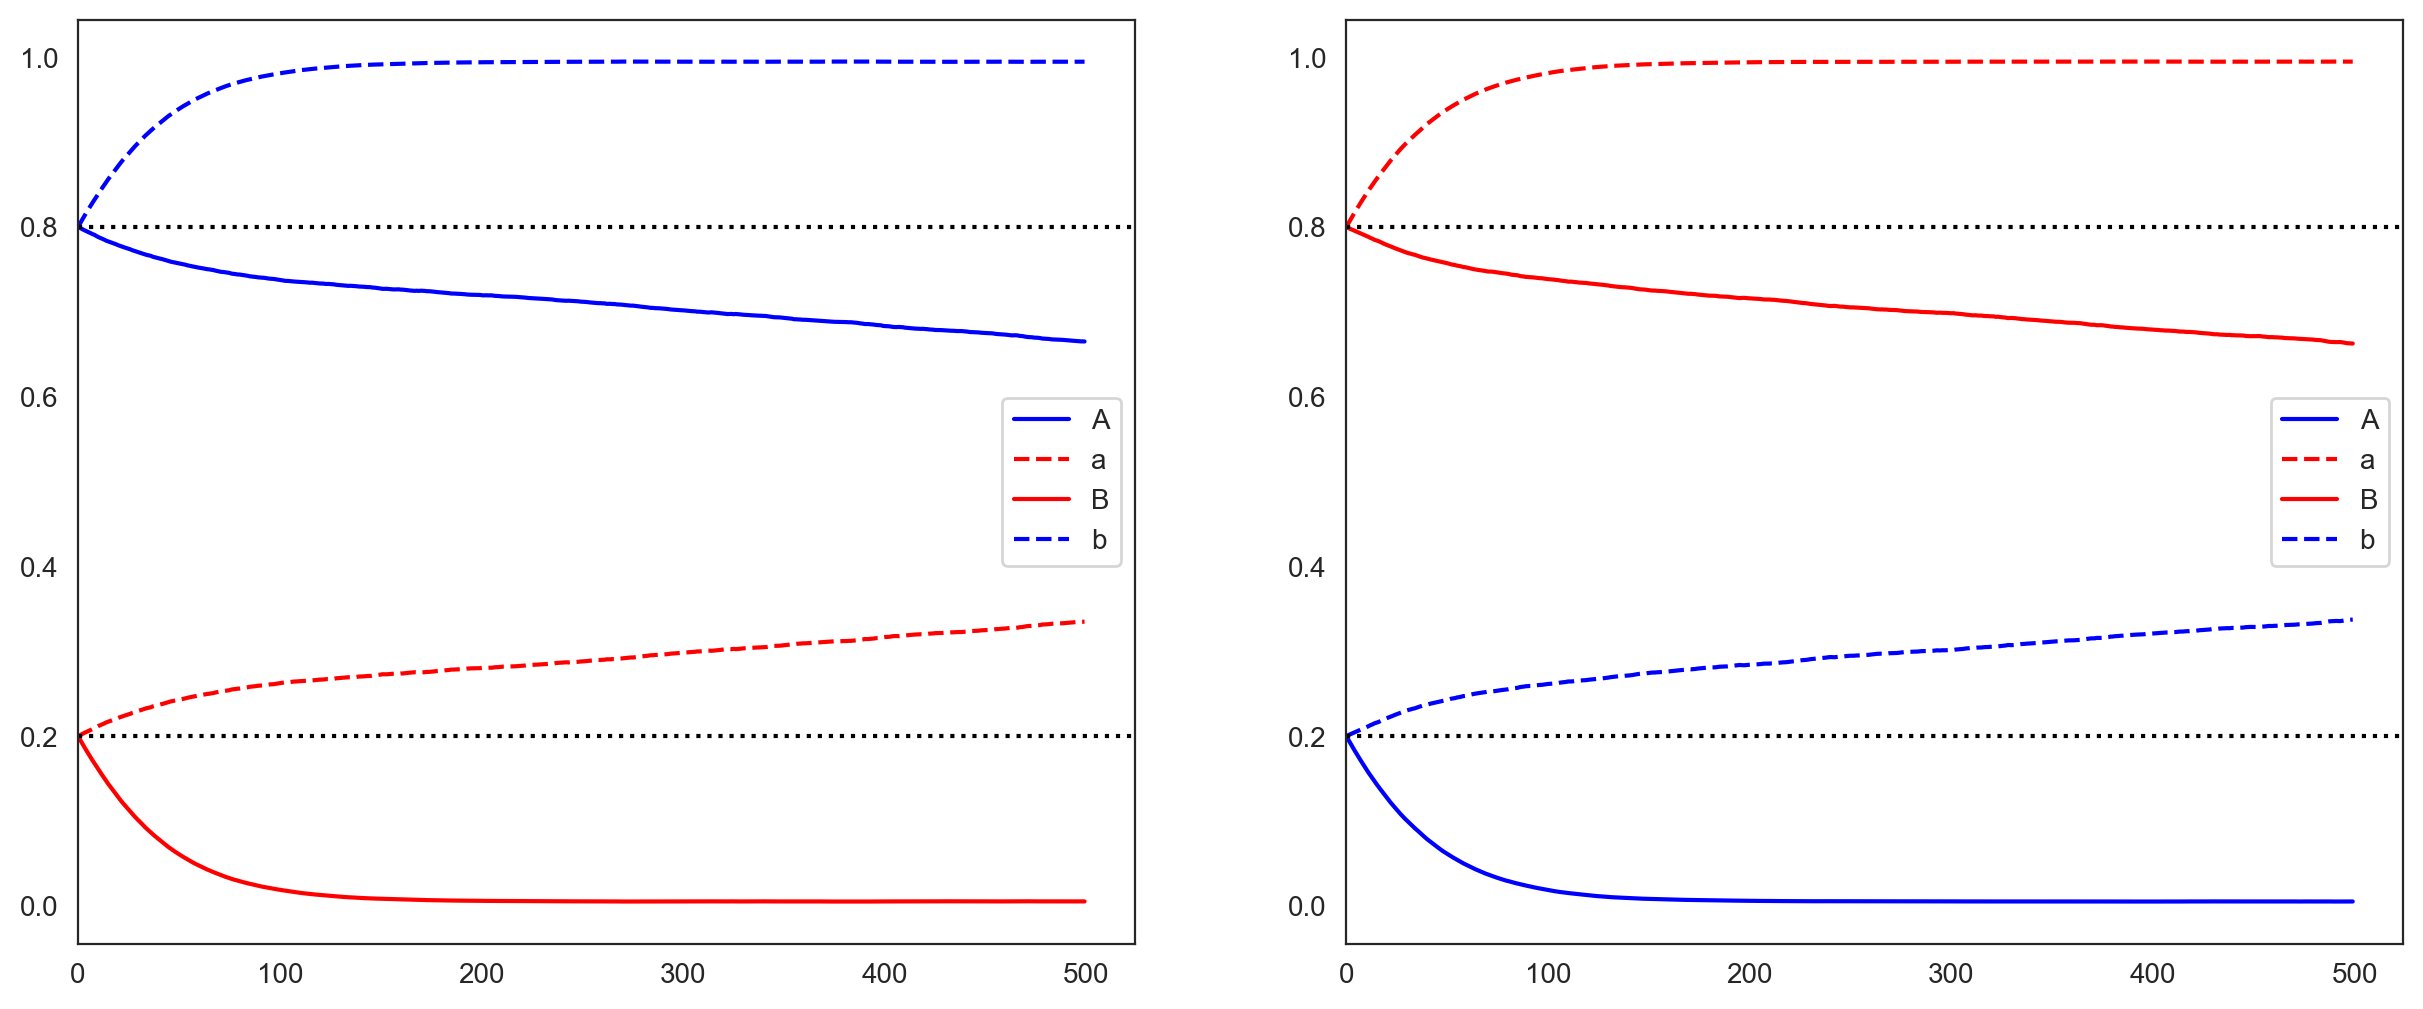

In [30]:
startmix = 0.2
data = compute_twolocus_sample_data(5000000, 1000, 0.02, 500, startmix=startmix, bdmi=True)
plot()

If contributing, BDMI only contributes the correlation an extra boost right after the initial mix.

With only BDMI, the correlation does not increase after resolution of the incompatibility (after A or B are fixed). Maybe it is possible to get at this somehow?

## Compute the expected distribution of Spearman correlations

The distribution of spearman correlations dependes on both the number of samples, mean s and the distribution of s (here I use a gamma with shape 2):

In [10]:
# Diploid population size:
N = 50000
# scale migration rate (1 ballances drift and migration):
M = 0
# additive selection coeficient for bdmi:
s = 0.02 
# generations to simulate:
generations = 1000
# start minor parent proportion:
startmix = 0.2
# wether to simulate bdmi (negative selection on A B combinations):
bdmi = True
# whether to sample selection coeficients from a gamma with mean s (shape 2 and scale s/2):
gamma_s = True
# positive selection coeficient on A in pop1 and B in pop2:
pos_s = 0
# number of two-locus samples used to compute each correlation:
samples = 100
# number of independent replications:
replications = 100

rerun = True
if rerun:
    pool = Pool(cpu_count())
    data = np.empty((replications, samples, generations, 2, 4))
    for r in trange(replications):
        for i, sample_data in enumerate(pool.starmap(compute_twolocus_sample_data, 
                                                     [(N, M, s, generations, startmix,
                                                       bdmi, pos_s, gamma_s)] * samples)):
            data[r][i] = sample_data        
    with open(f'data.npy', 'wb') as f:
        np.save(f, data)
else:
    with open(f'data.npy', 'rb') as f:
        data = np.load(f)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/kmt/miniconda3/envs/bdmi/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/kmt/miniconda3/envs/bdmi/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/kmt/miniconda3/envs/bdmi/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/kmt/miniconda3/envs/bdmi/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/kmt/miniconda3/envs/bdmi/lib/pyth

In [11]:
import warnings
warnings.filterwarnings("error")

def spearman(a, b):
    import scipy
    try:
        return scipy.stats.spearmanr(a, b).correlation
    except scipy.stats.SpearmanRConstantInputWarning:
        return np.nan
    
spearman_vals = np.empty((replications, generations))
for r in trange(replications):
    
    a = np.transpose(data[r, :, :, 0, 3])
    b = np.transpose(data[r, :, :, 1, 3])
    
    spearman_vals[r] = pool.starmap(spearman, zip(a, b))

  0%|          | 0/100 [00:00<?, ?it/s]

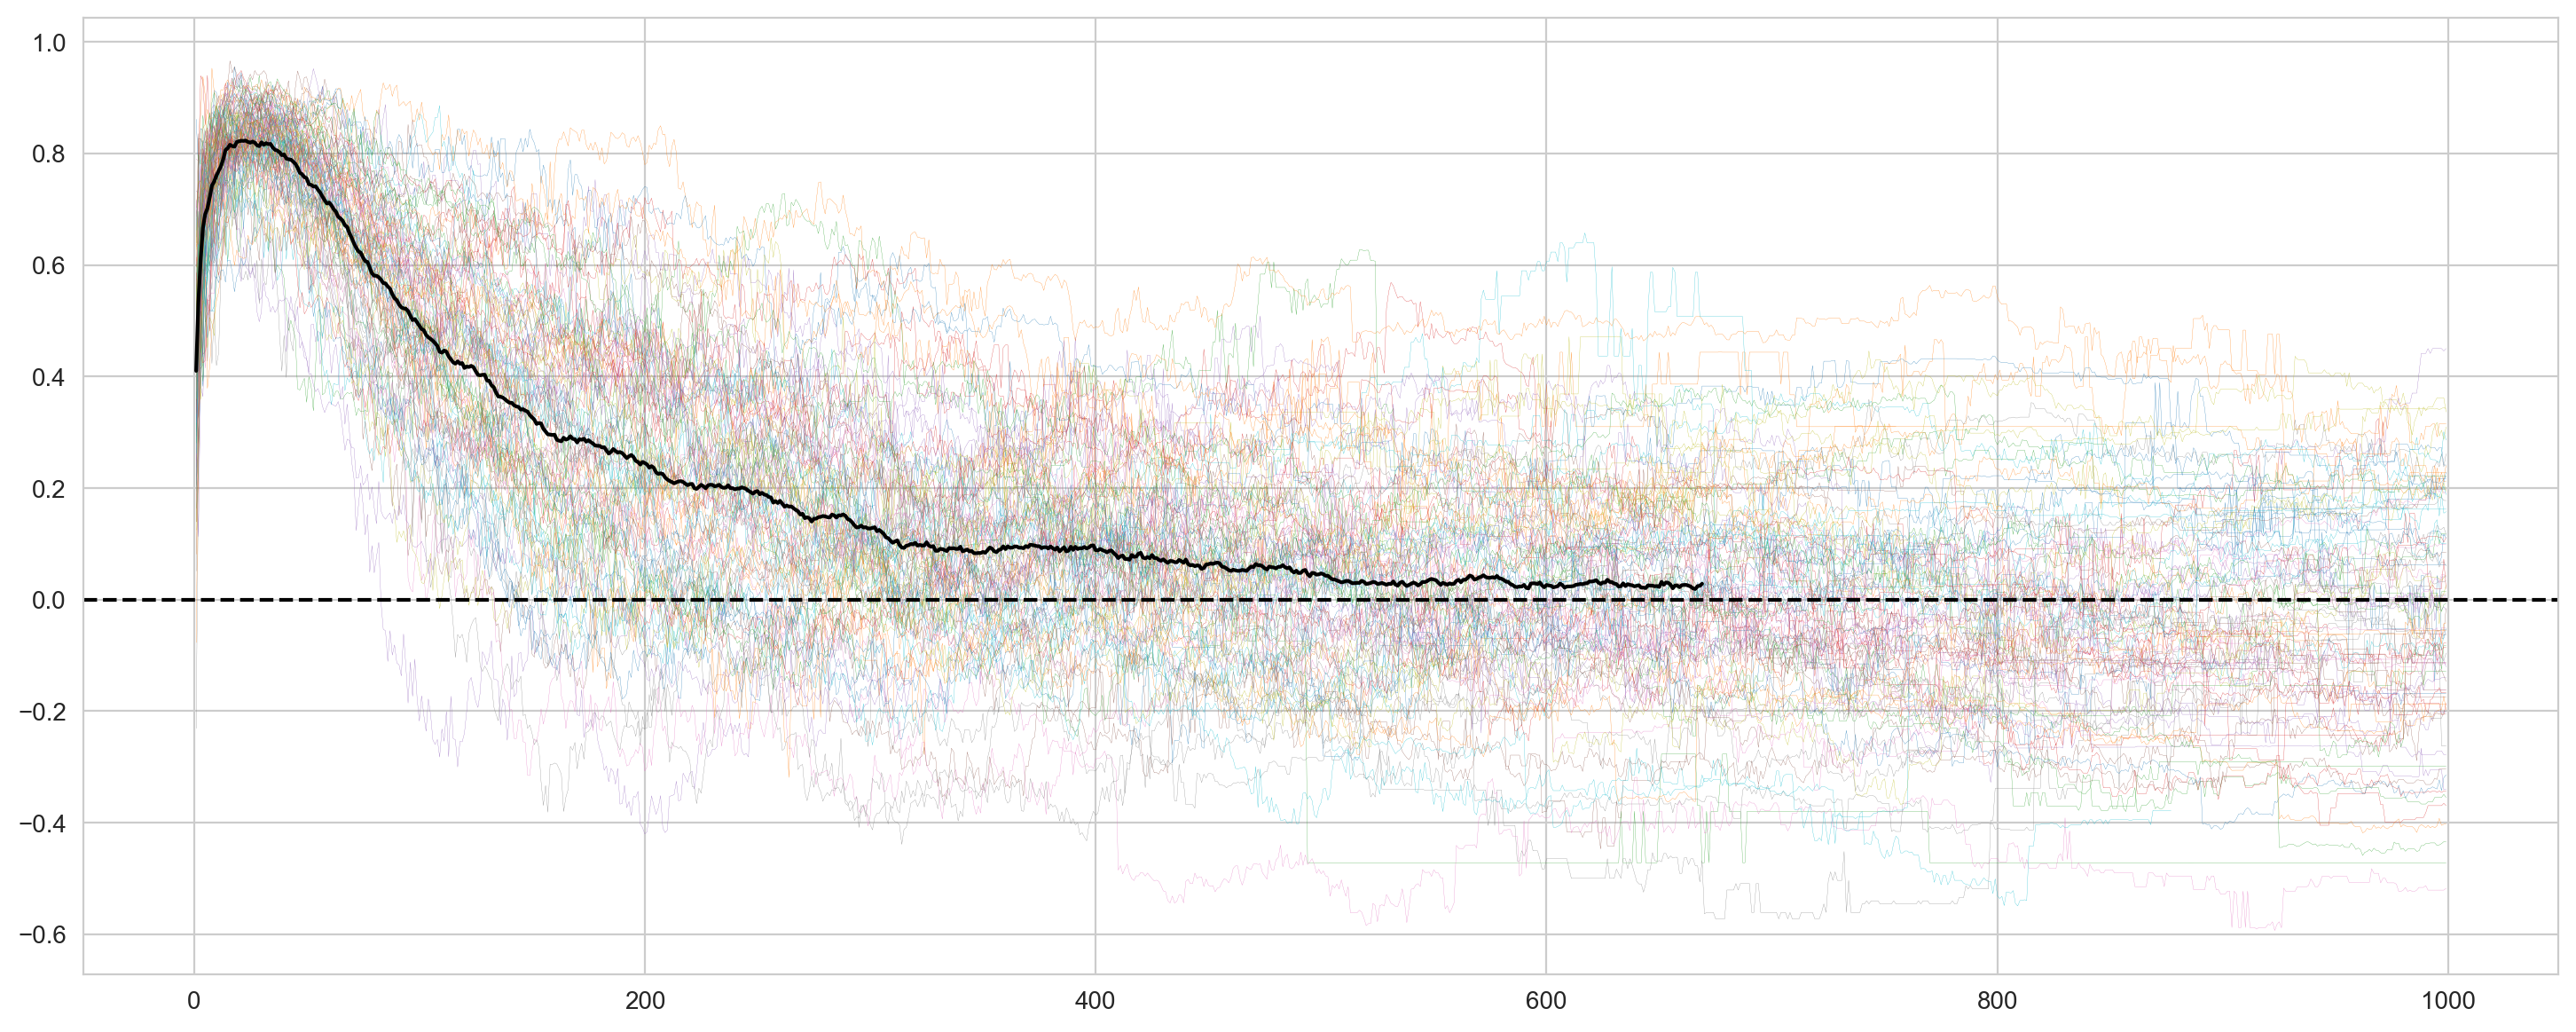

In [12]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(18,7))
    for i in range(replications):
        plt.plot(spearman_vals[i], linewidth=0.1)
    plt.plot(np.array(spearman_vals).mean(0), color='black')
    plt.axhline(y=0, color='black', linestyle='dashed')

In [32]:

def compute_twolocus_sample_data(N, M, s, g, startmix=(1, 1), bdmi=True, pos_s=(0, 0), gamma_s=False):
        
    if gamma_s:
        s = (gamma(2, s[0]/2, 1)[0], gamma(2, s[1]/2, 1)[0])
    
    m = (M[0] / N[0], M[1] / N[1])
    
    data = np.empty((g, 2, 4)) # gen, pop, alleles A, a, B, b (pops start out as AA bb, and aa BB, e.g. freq pop1: 1,1,0,0)
    
    data[0][0] = np.array([1-startmix[0], startmix[0], startmix[0], 1-startmix[0]])
    data[0][1] = np.array([startmix[1], 1-startmix[1], 1-startmix[1], startmix[1]])

    for g in range(1, g):
        # new generations
        for pop in range(2):

            f_A, f_a, f_B, f_b = data[g-1][pop]
            
            # construct genotypes
            locus1_genotypes = (f_A*f_A, 2*f_A*f_a, f_a*f_a)
            locus2_genotypes = (f_B*f_B, 2*f_B*f_b, f_b*f_b)
            
            # two locus genotypes
            genotypes = []
            for i in locus1_genotypes:
                row = []
                for j in locus2_genotypes:
                    row.append(i*j)
                genotypes.append(row)
            genotypes = np.array(genotypes)
            assert round(genotypes.sum(), 10) == 1, genotypes.sum()

            if bdmi:
                # selection against A B combinations (BDMI)
                sel = np.array([[1-2*s[0], 1-2*s[0], 1],
                                [1-2*s[0], 1-s[0], 1],
                                [1,   1,   1]])
            else:
                # just selection against B in pop 0 and A in pop 1 (ecological selection)
                if pop == 0:
                    sel = np.array([[1-2*s[0], 1-s[0], 1],
                                    [1-2*s[0], 1-s[0], 1],
                                    [1-2*s[0], 1-s[0], 1]])
                else:
                    sel = np.array([[1-2*s[0], 1-2*s[0], 1-2*s[0]],
                                    [1-s[0], 1-s[0], 1-s[0]],
                                    [1,   1,   1]])
            if any(pos_s):
                # positive selection on A and B
                a = np.array([1+2*pos_s[0], 1+pos_s[0], 1])
                if pop == 0:
                    sel = (sel.T * a).T
                else:
                    sel = sel * a

            genotypes_sampling_prob = genotypes * sel
            genotypes_sampling_prob /= genotypes_sampling_prob.sum()
            assert round(genotypes_sampling_prob.sum(), 10) == 1, genotypes_sampling_prob.sum()
            
            counts = np.random.multinomial(N[pop], genotypes_sampling_prob.flatten()).reshape((3, 3))

            f_A = counts[0, :].sum()*2 + counts[1, :].sum()
            f_a = counts[1, :].sum() + counts[2, :].sum()*2
            f_A, f_a = f_A / (f_A + f_a), f_a / (f_A + f_a)
            
            f_B = counts[:, 0].sum()*2 + counts[:, 1].sum()
            f_b = counts[:, 1].sum() + counts[:, 2].sum()*2
            f_B, f_b = f_B / (f_B + f_b), f_b / (f_B + f_b)

            new_freqs = np.array([f_A, f_a, f_B, f_b])
            assert round(new_freqs.sum(), 10) == 2, new_freqs
            data[g][pop] = new_freqs

        data[g][0], data[g][1] = (1-m[0])*data[g][0] + m[0]*data[g][1], (1-m[1])*data[g][1] + m[1]*data[g][0]

    return data


In [33]:
def plot(labels=['A', 'a', 'B', 'b'], startmix=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
    for x, label in zip(data[:, 0, :].transpose(), labels):
        ax1.plot(x, label=label)
    ax1.legend()    
    ax2.set_prop_cycle(color=['blue', 'red', 'red', 'blue'], linestyle=['solid', 'dashed', 'solid', 'dashed'])    
    for x, label in zip(data[:, 1, :].transpose(), labels):
        ax2.plot(x, label=label)   
    ax2.legend() ;

    ax1.set_xlim(left=0)
    ax2.set_xlim(left=0)
    ax1.set_ylim((0, 1))
    ax2.set_ylim((0, 1))
    ax1.title.set_text('Population 1')
    ax2.title.set_text('Population 2')
    ax1.axhline(y=1-startmix[0], linestyle='dotted', color='black')
    ax1.axhline(y=startmix[0], linestyle='dotted', color='black')
    ax2.axhline(y=1-startmix[1], linestyle='dotted', color='black')
    ax2.axhline(y=startmix[1], linestyle='dotted', color='black') ;

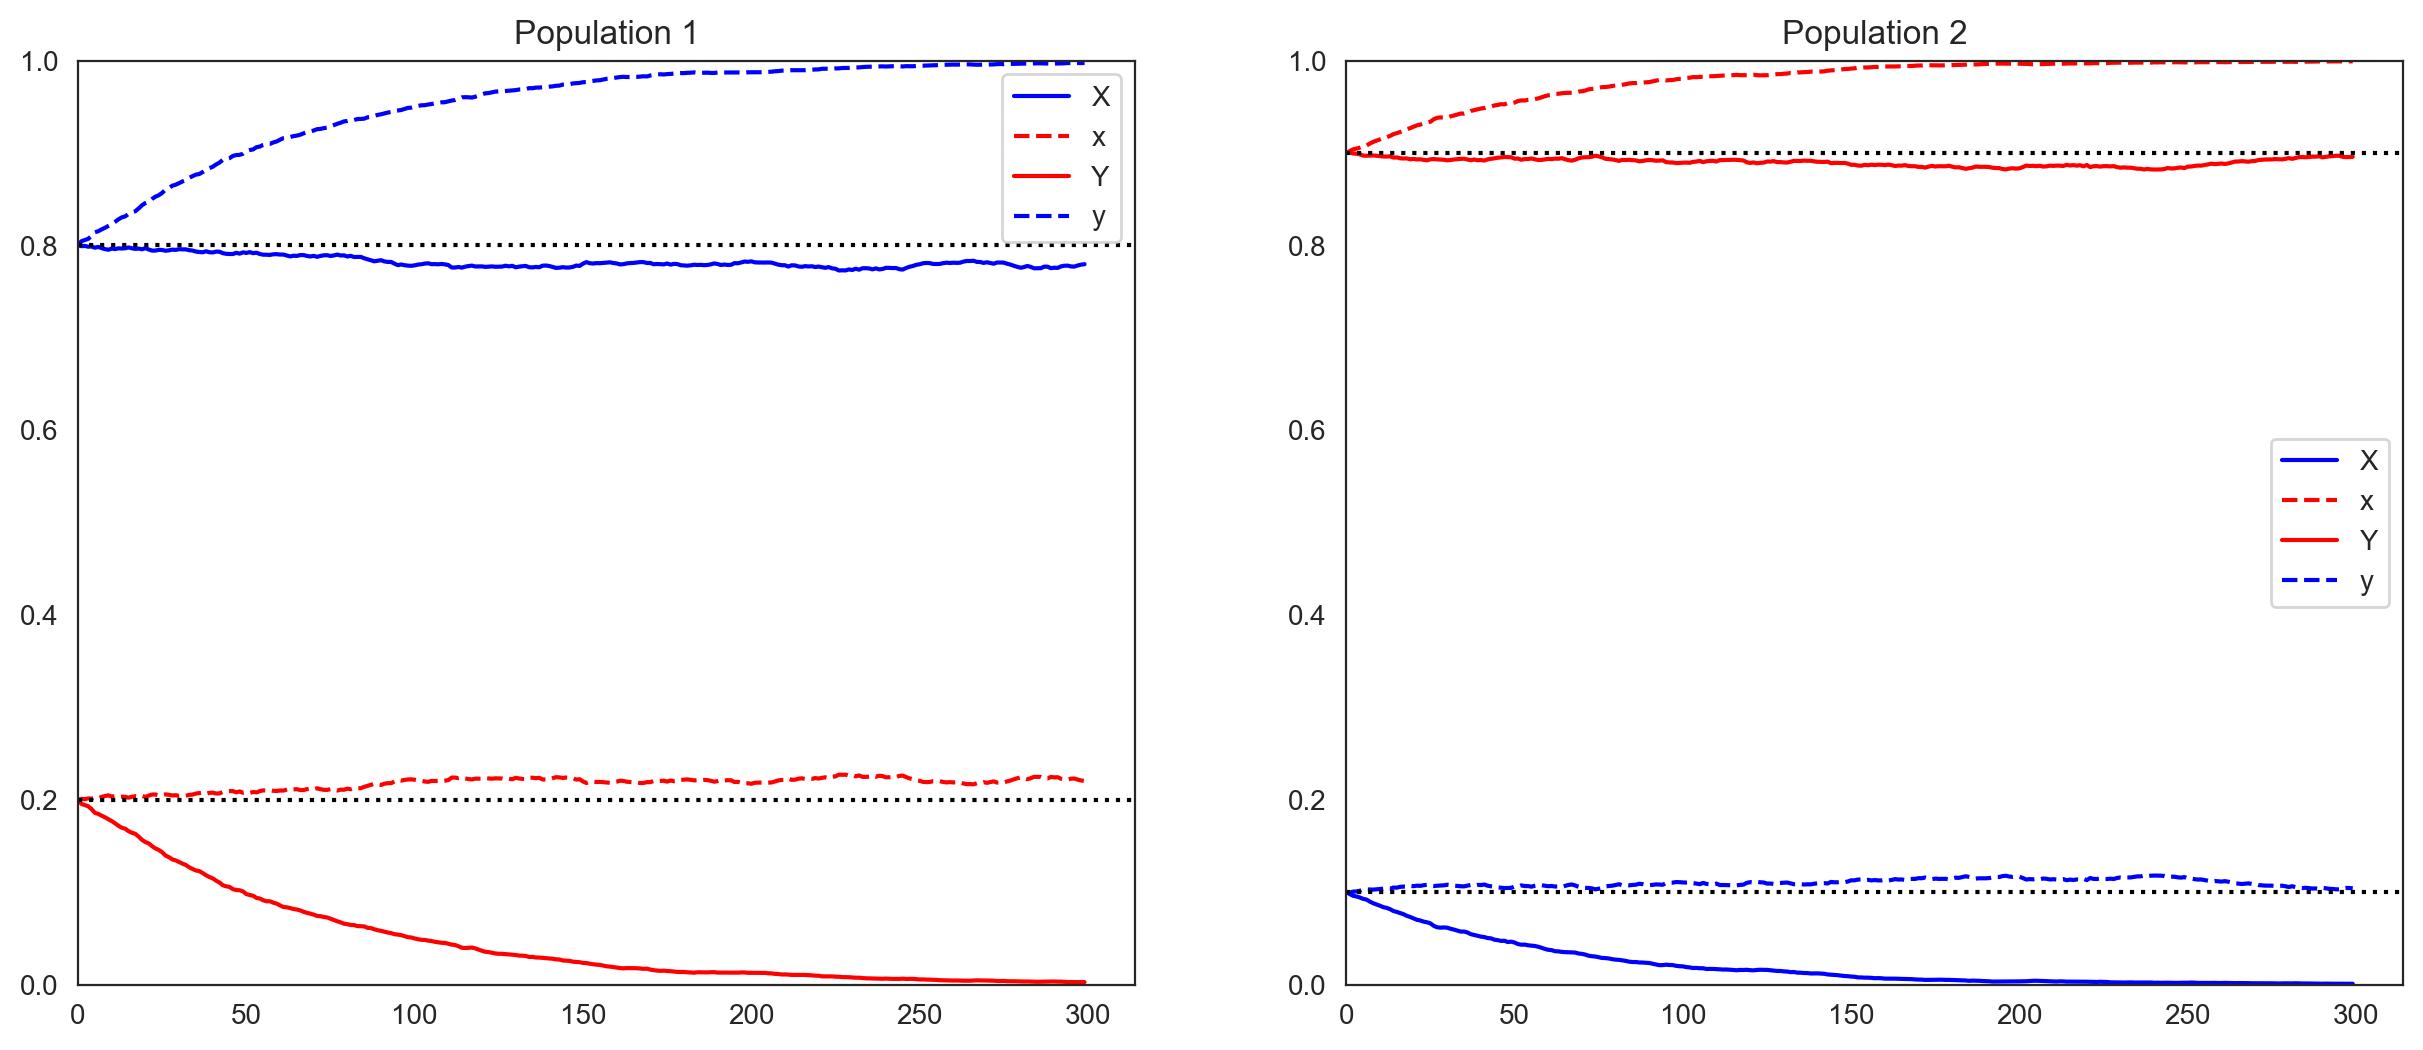

In [34]:
startmix = (0.2, 0.1)
data = compute_twolocus_sample_data(N=(100000, 100000), M=(0, 0), s=(0.01, 0.01), g=300, startmix=startmix, bdmi=True)
plot(['X', 'x', 'Y', 'y'], startmix)

With continued migration (influx of new Neanderthal Ys)

In [35]:
startmix = 0.2
data = compute_twolocus_sample_data(100000, 1000, 0.01, 300, startmix=startmix, bdmi=True)
plot(['Hum X', 'Nean x', 'Nean Y', 'Hum y'])

TypeError: 'int' object is not subscriptable

The offending X an Y combinations are eventually removed. The Neanderthal allele compatible with the human Y eventually takes over the human population (and vice versa). This selection pressure would also propel a human X allele with the same properties as the Neanderthal X to the same high frequency...

Could that also explain invasions of X and Y from humans into neanderthals?... If the human Y is not inocmpatible with nean X but nean Nean Y is incompatible with human X?

If a rare human X variant (compatible with Neanderthal Y) would be selected on a background of incompatible X variants, then the neanderthal X variant would be selected too (because that is also compatible with the Neanderhal Y) - and we don't see that. However, it could be that the Neanderthal X is not selected because it is incompatbile with the Human Y.

    Human              Nean
    X    incomp with    Y 
    Y    incomp with    X
    X'  not incomp with Y


However, since we see that X' also displaces Denisovan admixture, it whould to also be compatible with Denisovan Y. Upon admixture with Denisovans (with more archaic incomp Ys mixing in) the X' should rise further in frequency, which we do not see. Further, any Denisovan segments that land on X' haplotypes at this point would not be displaced by selection on X'. Alternatively, X' could be from a seperate population in East Asia/Oceania (just like we think a a driver might), and then spread across Eurasia, displaceing both kinds of arhaic admixture just like we think a driver might. But in *that* case there would be no subsequent influx of more archaic Y's (requited to propel X' to high freqs). It would work just like BDMI with a single pulse of admixture, and X' would only rise modestly in frequency before the resident archaic Y's had been removed.

For the model to work in Human -> Neanderthal introgression it would not only require that Human Y is not incompatible with Neanderthal X. It would also require positive selection on Human Y (if it did not fix by chance). 